In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "your api key"

In [ ]:
!pip install langchain chromadb faiss-cpu openai tiktoken langchain_openai langchain-community wikipedia

A **Retriever** is a component in LangChain that fetches relevant documents from data source in response to a user's query

- There are multiple types of retrievers and All retrievers in LangChain are runnables

- Retrievers accept a string query as input and return a list of Documents as output.

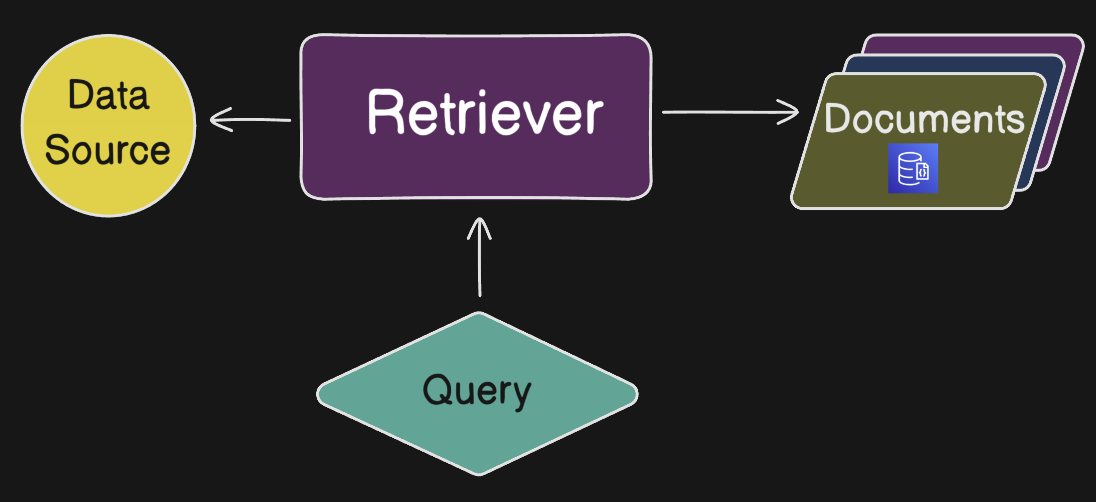

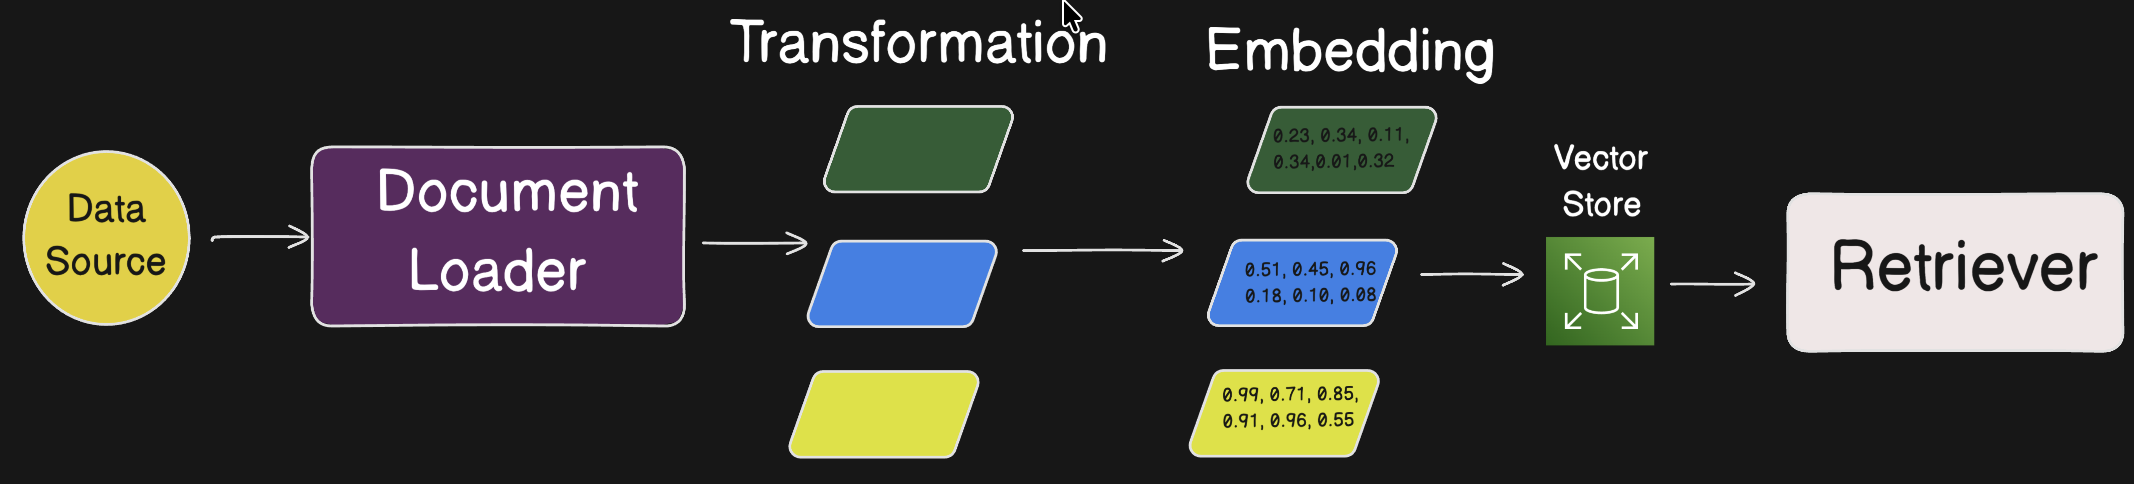

## Wikipedia Retriever

In [ ]:
from langchain_community.retrievers import WikipediaRetriever

- A Wikipedia Retriever is a retriever that queries the Wikipedia API to fetch relevant content for a given query.
How It Works
1. You give it a query (e.g., "Albert Einstein")
2. It sends the query to Wikipedia's API
3. It retrieves the most relevant articles
4. It returns them as LangChain Document objects

In [ ]:
# Initialize the retriever (optional: set language and top_k)
retriever = WikipediaRetriever(top_k_results=2, lang="en")

In [ ]:

# Define your query
query = "the geopolitical history of india and pakistan from the perspective of a chinese"

# Get relevant Wikipedia documents
docs = retriever.invoke(query)

In [ ]:
docs

[Document(metadata={'title': 'United States aid to Pakistan', 'summary': 'The United States had been providing military aid and economic assistance to Pakistan for various purposes since 1948. Recently U.S. stopped military aid to Pakistan, which was about US$2 billion per year. With U.S. military assistance suspended in 2018 and civilian aid reduced to about $300 million for 2022, Pakistani authorities have turned to other countries for help.', 'source': 'https://en.wikipedia.org/wiki/United_States_aid_to_Pakistan'}, page_content="The United States had been providing military aid and economic assistance to Pakistan for various purposes since 1948. Recently U.S. stopped military aid to Pakistan, which was about US$2 billion per year. With U.S. military assistance suspended in 2018 and civilian aid reduced to about $300 million for 2022, Pakistani authorities have turned to other countries for help.\n\n\n== History ==\nFrom 1947 to 1958, under civilian leadership, the United States prov

In [ ]:
# Print retrieved content
for i, doc in enumerate(docs):
    print(f"\n--- Result {i+1} ---")
    print(f"Content:\n{doc.page_content}...")  # truncate for display


--- Result 1 ---
Content:
The United States had been providing military aid and economic assistance to Pakistan for various purposes since 1948. Recently U.S. stopped military aid to Pakistan, which was about US$2 billion per year. With U.S. military assistance suspended in 2018 and civilian aid reduced to about $300 million for 2022, Pakistani authorities have turned to other countries for help.


== History ==
From 1947 to 1958, under civilian leadership, the United States provided Pakistan with modest economic aid and limited military assistance. During this period, Pakistan became a member of the South East Asian Treaty Organization (SEATO) and the Central Treaty Organization (CENTO), after a Mutual Defence Assistance Agreement signed in May 1954, which facilitated increased levels of both economic and military aid from the U.S.
In 1958, Ayub Khan led Pakistan's first military coup, becoming Chief Martial Law Administrator (CMLA) and later President until 1969. During his tenure, 



---



# **Vector Store Retriever**

A Vector Store Retriever in LangChain is the most common type of retriever that lets you search and fetch documents from a vector store based on semantic similarity using vector embeddings.

How It Works
1. You store your documents in a vector store (like FAISS, Chroma, Weaviate)
2. Each document is converted into a dense vector using an embedding model
3. When the user enters a query:
   - It's also turned into a vector
   - The retriever compares the query vector with the stored vectors
   - It retrieves the top-k most similar ones

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

In [ ]:
# Step 1: Your source documents
documents = [
    Document(page_content="LangChain helps developers build LLM applications easily."),
    Document(page_content="Chroma is a vector database optimized for LLM-based search."),
    Document(page_content="Embeddings convert text into high-dimensional vectors."),
    Document(page_content="OpenAI provides powerful embedding models."),
]

In [ ]:
# Step 2: Initialize embedding model
embedding_model = OpenAIEmbeddings()

# Step 3: Create Chroma vector store in memory
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embedding_model,
    collection_name="my_collection"
)

In [ ]:
# Step 4: Convert vectorstore into a retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

In [ ]:
query = "What is Chroma used for?"
results = retriever.invoke(query)

In [ ]:
for i, doc in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)


--- Result 1 ---
Chroma is a vector database optimized for LLM-based search.

--- Result 2 ---
LangChain helps developers build LLM applications easily.


In [ ]:
results = vectorstore.similarity_search(query, k=2)

In [ ]:
for i, doc in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)


--- Result 1 ---
Chroma is a vector database optimized for LLM-based search.

--- Result 2 ---
LangChain helps developers build LLM applications easily.




---



# Maximal Marginal Relevance (MMR)

"How can we pick results that are not only relevant to the query but also different from each other?" <br>

MMR is an information retrieval algorithm designed to reduce redundancy in the retrieved esults while maintaining high relevance to the query.  <br>

Why MMR Retriever?  <br>
In regular similarity search, you may get documents that are:
  - All very similar to each other
  - Repeating the same info
  - Lacking diverse perspectives


MMR Retriever avoids that by:  <br>
   - Picking the most relevant document first  <br>
   - Then picking the next most relevant and least similar to already selected docs  <br>

This helps especially in RAG pipelines where:  <br>
 - You want your context window to contain diverse but still relevant information
 - Especially useful when documents are semantically overlapping

In [ ]:
# Sample documents
docs = [
    Document(page_content="LangChain makes it easy to work with LLMs."),
    Document(page_content="LangChain is used to build LLM based applications."),
    Document(page_content="Chroma is used to store and search document embeddings."),
    Document(page_content="Embeddings are vector representations of text."),
    Document(page_content="MMR helps you get diverse results when doing similarity search."),
    Document(page_content="LangChain supports Chroma, FAISS, Pinecone, and more."),
]

In [ ]:
from langchain_community.vectorstores import FAISS

# Initialize OpenAI embeddings
embedding_model = OpenAIEmbeddings()

# Step 2: Create the FAISS vector store from documents
vectorstore = FAISS.from_documents(
    documents=docs,
    embedding=embedding_model
)

In [ ]:
# Enable MMR in the retriever
retriever = vectorstore.as_retriever(
    search_type="mmr",                   # <-- This enables MMR
    search_kwargs={"k": 3, "lambda_mult": 0.5}  # k = top results, lambda_mult = relevance-diversity balance
)

In [ ]:
query = "What is langchain?"
results = retriever.invoke(query)

In [ ]:
for i, doc in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)


--- Result 1 ---
LangChain is used to build LLM based applications.

--- Result 2 ---
Embeddings are vector representations of text.

--- Result 3 ---
LangChain supports Chroma, FAISS, Pinecone, and more.




---



# **Multiquery Retriever**

Sometimes a single query may not capture all the ways information is phrased in your documents. <br>

example: <br>
Query: "How can I stay healthy?" <br>
Could mean: <br>
• What should I eat?<br>
• How often should I exercise?<br>
• How can I manage stress? <br>

A simple similarity search can miss documents that talk about those things but don't use the word - "healthy."
1. Takes your original query
2. Uses an LLM (e.g GPT-3.5) to generate multiple semantically different versions of that query
3. Performs retrieval for each sub-query
4. Combines and deduplicates the results

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

In [ ]:
# Relevant health & wellness documents
all_docs = [
    Document(page_content="Regular walking boosts heart health and can reduce symptoms of depression.", metadata={"source": "H1"}),
    Document(page_content="Consuming leafy greens and fruits helps detox the body and improve longevity.", metadata={"source": "H2"}),
    Document(page_content="Deep sleep is crucial for cellular repair and emotional regulation.", metadata={"source": "H3"}),
    Document(page_content="Mindfulness and controlled breathing lower cortisol and improve mental clarity.", metadata={"source": "H4"}),
    Document(page_content="Drinking sufficient water throughout the day helps maintain metabolism and energy.", metadata={"source": "H5"}),
    Document(page_content="The solar energy system in modern homes helps balance electricity demand.", metadata={"source": "I1"}),
    Document(page_content="Python balances readability with power, making it a popular system design language.", metadata={"source": "I2"}),
    Document(page_content="Photosynthesis enables plants to produce energy by converting sunlight.", metadata={"source": "I3"}),
    Document(page_content="The 2022 FIFA World Cup was held in Qatar and drew global energy and excitement.", metadata={"source": "I4"}),
    Document(page_content="Black holes bend spacetime and store immense gravitational energy.", metadata={"source": "I5"}),
]

In [ ]:
# Initialize OpenAI embeddings
embedding_model = OpenAIEmbeddings()

# Create FAISS vector store
vectorstore = FAISS.from_documents(documents=all_docs, embedding=embedding_model)

In [ ]:
# Create retrievers
similarity_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [ ]:
multiquery_retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(search_kwargs={"k": 5}),
    llm=ChatOpenAI(model="gpt-3.5-turbo")
)

In [ ]:
# Query
query = "How to improve energy levels and maintain balance?"

In [ ]:
# Retrieve results
similarity_results = similarity_retriever.invoke(query)
multiquery_results= multiquery_retriever.invoke(query)

In [ ]:
for i, doc in enumerate(similarity_results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)

print("*"*150)

for i, doc in enumerate(multiquery_results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)


--- Result 1 ---
Drinking sufficient water throughout the day helps maintain metabolism and energy.

--- Result 2 ---
Mindfulness and controlled breathing lower cortisol and improve mental clarity.

--- Result 3 ---
Regular walking boosts heart health and can reduce symptoms of depression.

--- Result 4 ---
Deep sleep is crucial for cellular repair and emotional regulation.

--- Result 5 ---
The solar energy system in modern homes helps balance electricity demand.
******************************************************************************************************************************************************

--- Result 1 ---
Drinking sufficient water throughout the day helps maintain metabolism and energy.

--- Result 2 ---
Mindfulness and controlled breathing lower cortisol and improve mental clarity.

--- Result 3 ---
Regular walking boosts heart health and can reduce symptoms of depression.

--- Result 4 ---
Consuming leafy greens and fruits helps detox the body and improve lo



---



## ContextualCompressionRetriever

The Contextual Compression Retriever in LangChain is an advanced retriever that improves retrieval quality by compressing documents after retrieval — keeping only the relevant content based on the user's query.

Query: 'What is photosynthesis?' <br>
Retrieved Document (by traditional retriever): <br>
"The Grand Canyon is a famous natural site.  <br>
Photosynthesis is how plants convert light into energy.<br>
Many tourists visit every year. <br>

Problem:
- The retriever returns the entire paragraph
- Only one sentence is actually relevant to the query
- The rest is irrelevant noise that wastes context window and may confuse the LLM

What Contextual Compression Retriever does: returns only relevant part <br>
'Photosynthesis is how plants convert light into energy.'

How It Works
1. Base Retriever (e.g FAISS, Chroma) retrieves N documents.
2. compressor (LLM model) is applied to each document.
3. The compressor keeps only the parts relevant to the query.
4. Irrelevant content is discarded/ removed.


When to Use<br>
• Your documents are long and contain mixed information<br>
• You want to reduce context length for LLMs<br>
• You need to improve answer accuracy in RAG pipelines<br>

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_core.documents import Document

In [ ]:
# Recreate the document objects from the previous data
docs = [
    Document(page_content=(
        """The Grand Canyon is one of the most visited natural wonders in the world.
        Photosynthesis is the process by which green plants convert sunlight into energy.
        Millions of tourists travel to see it every year. The rocks date back millions of years."""
    ), metadata={"source": "Doc1"}),

    Document(page_content=(
        """In medieval Europe, castles were built primarily for defense.
        The chlorophyll in plant cells captures sunlight during photosynthesis.
        Knights wore armor made of metal. Siege weapons were often used to breach castle walls."""
    ), metadata={"source": "Doc2"}),

    Document(page_content=(
        """Basketball was invented by Dr. James Naismith in the late 19th century.
        It was originally played with a soccer ball and peach baskets. NBA is now a global league."""
    ), metadata={"source": "Doc3"}),

    Document(page_content=(
        """The history of cinema began in the late 1800s. Silent films were the earliest form.
        Thomas Edison was among the pioneers. Photosynthesis does not occur in animal cells.
        Modern filmmaking involves complex CGI and sound design."""
    ), metadata={"source": "Doc4"})
]

In [ ]:
# Create a FAISS vector store from the documents
embedding_model = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(docs, embedding_model)

In [ ]:
base_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

In [ ]:
# Set up the compressor using an LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")
compressor = LLMChainExtractor.from_llm(llm)

In [ ]:
# Create the contextual compression retriever
compression_retriever = ContextualCompressionRetriever(
    base_retriever=base_retriever,
    base_compressor=compressor
)

In [ ]:
# Query the retriever
query = "What is photosynthesis?"
compressed_results = compression_retriever.invoke(query)

In [ ]:
for i, doc in enumerate(compressed_results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)



--- Result 1 ---
Photosynthesis is the process by which green plants convert sunlight into energy.

--- Result 2 ---
The chlorophyll in plant cells captures sunlight during photosynthesis.




---

